In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import xesmf
import cf_xarray
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
hdi_ds = xr.open_dataset('/home/563/rl5183/Downloads/HDI_1990_2015_1x1.nc')
hdi = hdi_ds.HDI.sel(time=2015)
std_txx_cor = xr.open_dataarray('/g/data/w40/rl5183/20CR/temp/TXx_ensemble_std_corr_1901_2015.nc')
std_tnn_cor = xr.open_dataarray('/g/data/w40/rl5183/20CR/temp/TNn_ensemble_std_corr_1901_2015.nc')
std_mean_tmp = xr.open_dataarray('/g/data/w40/rl5183/20CR/temp/tmp_ensemble_std_corr_1901_2015.nc')

In [3]:
pop = xr.open_dataset('/g/data/w40/rl5183/gpw_v4_population_density_rev11_1_deg.nc')
pop_2015 = pop.sel(raster=4) # raster 4 is population density for 2015 (see csv file in zip for details of other rasters)

In [4]:
# Regrid population data 
ds_bnds = pop.cf.add_bounds(['latitude','longitude'])
sample_bnds = hdi_ds.cf.add_bounds(['lat','lon'])
regrid = xesmf.Regridder(ds_bnds, sample_bnds, method='conservative_normed')
pop_2015_rg = regrid(pop_2015)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


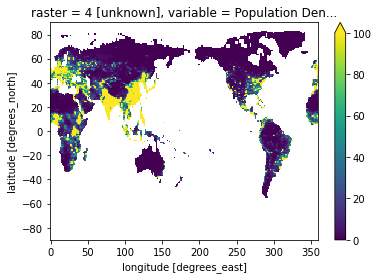

In [5]:
pop_data = pop_2015_rg.to_array().sel(variable='Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 1 degree')
pop_data.plot(vmax=100)

In [6]:
# Use regridder on mean tmp std 
std_mean_rg = regrid(std_mean_tmp)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


### Color code by latitude 

In [7]:
# You need to get rid of the NaN. For this you first need to make sure all the data have the same land/sea mask.
# Create a mask that masks any NaN in the 3 fields, take only the first time for std_rx1_cor assuming the mask is the same for all times:
allmask = pop_data * hdi * std_txx_cor[0]

# Apply to all fields. The following will keep the field where allmask is not NaN and put NaN otherwise.
hdi = hdi.where(np.isfinite(allmask))
pop_data = pop_data.where(np.isfinite(allmask))
std_txx_cor = std_txx_cor.where(np.isfinite(allmask))
std_tnn_cor = std_tnn_cor.where(np.isfinite(allmask))

In [8]:
# Define the regions
regions = {
    "Tropics":slice(-23.5,23.5),
    "Subtropics NH":slice(23.5,35.5),
    "Subtropics SH":slice(-35.5, -23.5),
    "Mid latitudes NH":slice(35.5, 66.5),
    "Mid latitudes SH":slice(-66.5, -35.5),
}

In [9]:
# Loop over the regions to create a Dataset with the data for the various regions in different DataArrays. 
# I would normally transform this loop in a function to use it easily on the other fields.
hdi_by_lat = []
for reg_name,reg_loc in regions.items():
    hdi_sliced = hdi.sel(lat=reg_loc).rename(reg_name)
    hdi_by_lat.append(hdi_sliced)
hdi_by_lat = xr.merge(hdi_by_lat)
hdi_by_lat

<xarray.Dataset>
Dimensions:           (lat: 134, lon: 360)
Coordinates:
  * lat               (lat) float64 -66.5 -65.5 -64.5 -63.5 ... 64.5 65.5 66.5
    time              float32 2.015e+03
  * lon               (lon) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    raster            int32 4
    variable          <U66 'Population Density, v4.11 (2000, 2005, 2010, 2015...
    month             int64 2
Data variables:
    Tropics           (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    Subtropics NH     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    Subtropics SH     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    Mid latitudes NH  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    Mid latitudes SH  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    long_name:  Human Development Index (HDI)
    units:      dimensionless indicator

In [10]:
# Apply same loop to the other fields. That's where a function would be handy.
pop_by_lat = []
for reg_name,reg_loc in regions.items():
    pop_sliced = pop_data.sel(lat=reg_loc).rename(reg_name)
    pop_by_lat.append(pop_sliced)
pop_by_lat = xr.merge(pop_by_lat)

txx_by_lat = []
for reg_name,reg_loc in regions.items():
    txx_sliced = std_txx_cor.sel(lat=reg_loc).rename(reg_name)
    txx_by_lat.append(txx_sliced)
txx_by_lat = xr.merge(txx_by_lat)

tnn_by_lat = []
for reg_name,reg_loc in regions.items():
    tnn_sliced = std_tnn_cor.sel(lat=reg_loc).rename(reg_name)
    tnn_by_lat.append(tnn_sliced)
tnn_by_lat = xr.merge(tnn_by_lat)

### Weight dot size by population 

In [11]:
s={}
for reg_name, reg_loc in regions.items():
    s[reg_name] = (pop_by_lat[reg_name].stack({"z":["lat","lon"]}).dropna("z"))**2/10**4

### Plot 

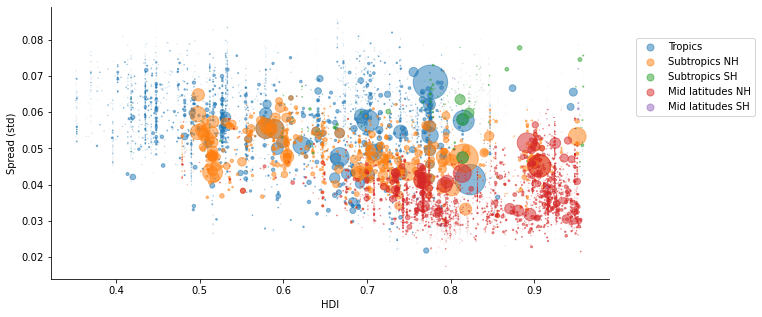

In [12]:
plt.figure(figsize=(10,5))
for reg_name, reg_loc in regions.items():
    plt.scatter(hdi_by_lat[reg_name].stack({"z":["lat","lon"]}).dropna("z"),
                txx_by_lat[reg_name].sel(month=11).stack({"z":["lat","lon"]}).dropna("z"),
                s=s[reg_name],label=reg_name, alpha=0.5)
lgnd = plt.legend(loc=(1.05, 0.6))
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]
lgnd.legendHandles[4]._sizes = [50]
plt.xlabel('HDI')
plt.ylabel('Spread (std)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

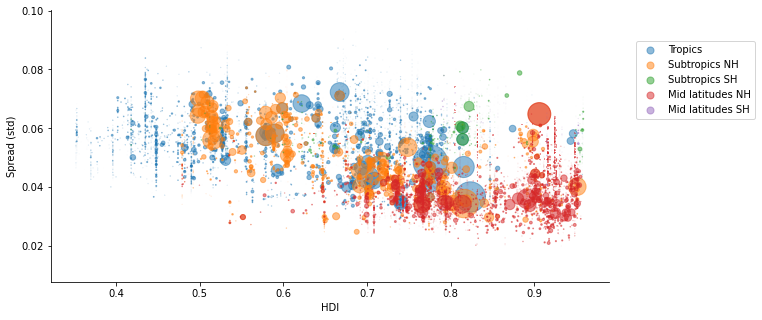

In [13]:
plt.figure(figsize=(10,5))
for reg_name, reg_loc in regions.items():
    plt.scatter(hdi_by_lat[reg_name].stack({"z":["lat","lon"]}).dropna("z"),
                tnn_by_lat[reg_name].sel(month=11).stack({"z":["lat","lon"]}).dropna("z"),
                s=s[reg_name],label=reg_name, alpha=0.5)
lgnd = plt.legend(loc=(1.05, 0.6))
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]
lgnd.legendHandles[4]._sizes = [50]
plt.xlabel('HDI')
plt.ylabel('Spread (std)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

### Repeat with Mean 

In [14]:
# Can use the same all mask as std_rx1 and std_mean are the same grids and coverage (should have no nans)
std_mean_tmp = std_mean_rg.where(np.isfinite(allmask))

In [15]:
# Loop over the regions to create a Dataset with the data for the various regions in different DataArrays
mean_by_lat = []
for reg_name,reg_loc in regions.items():
    mean_sliced = std_mean_tmp.sel(lat=reg_loc).rename(reg_name)
    mean_by_lat.append(mean_sliced)
mean_by_lat = xr.merge(mean_by_lat)

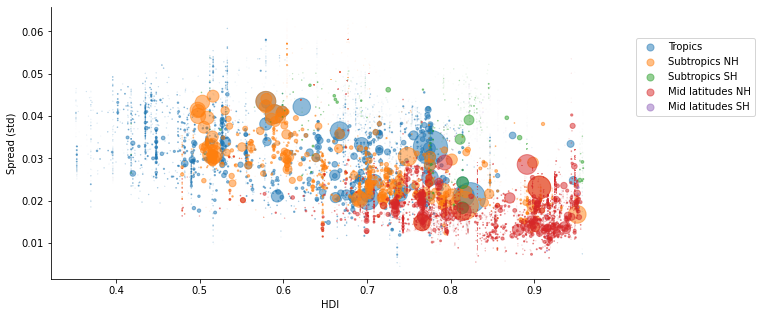

In [16]:
plt.figure(figsize=(10,5))
for reg_name, reg_loc in regions.items():
    plt.scatter(hdi_by_lat[reg_name].stack({"z":["lat","lon"]}).dropna("z"),
                mean_by_lat[reg_name].sel(month=11).stack({"z":["lat","lon"]}).dropna("z"),
                s=s[reg_name],label=reg_name, alpha=0.5)
lgnd = plt.legend(loc=(1.05, 0.6))
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]
lgnd.legendHandles[4]._sizes = [50]
plt.xlabel('HDI')
plt.ylabel('Spread (std)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## Make into one plot 

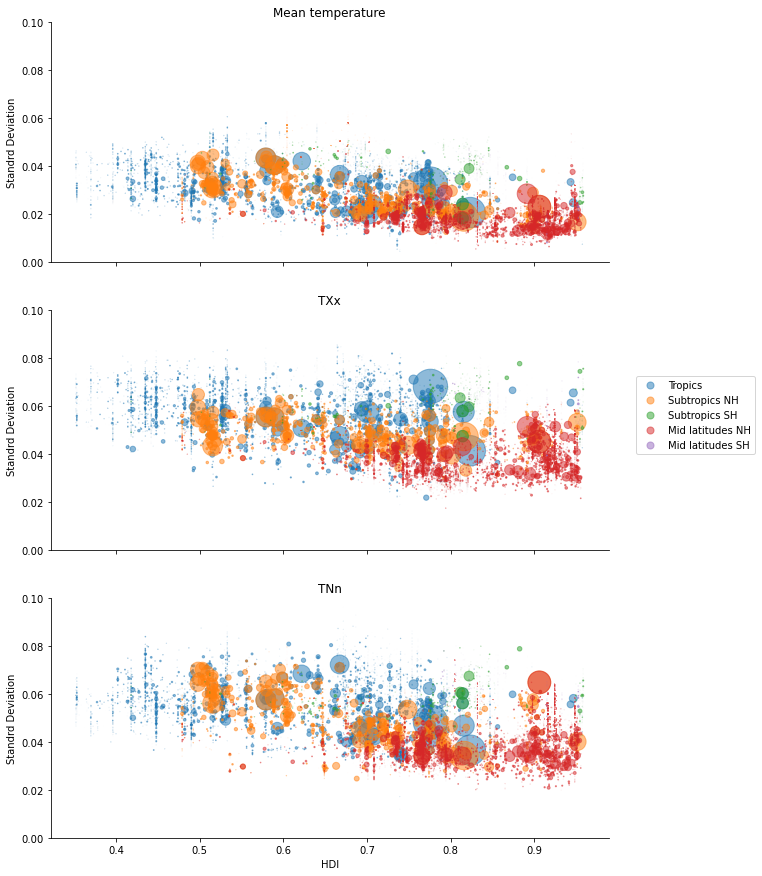

In [17]:
fig = plt.figure(figsize=(10,15))
axs = []

ax = fig.add_subplot(311)
for reg_name, reg_loc in regions.items():
    plt.scatter(hdi_by_lat[reg_name].stack({"z":["lat","lon"]}).dropna("z"),
                mean_by_lat[reg_name].sel(month=11).stack({"z":["lat","lon"]}).dropna("z"),
                s=s[reg_name],label=reg_name, alpha=0.5)
plt.ylim(0, 0.1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().axes.xaxis.set_ticklabels([])
plt.ylabel('Standrd Deviation')
ax.set_title('Mean temperature')
axs.append(ax)

ax = fig.add_subplot(312)
for reg_name, reg_loc in regions.items():
    ax.scatter(hdi_by_lat[reg_name].stack({"z":["lat","lon"]}).dropna("z"),
                txx_by_lat[reg_name].sel(month=11).stack({"z":["lat","lon"]}).dropna("z"),
                s=s[reg_name],label=reg_name, alpha=0.5)
plt.ylim(0, 0.1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().axes.xaxis.set_ticklabels([])
plt.ylabel('Standrd Deviation')
ax.set_title('TXx')
axs.append(ax)

ax = fig.add_subplot(313)
for reg_name, reg_loc in regions.items():
    ax.scatter(hdi_by_lat[reg_name].stack({"z":["lat","lon"]}).dropna("z"),
                tnn_by_lat[reg_name].sel(month=11).stack({"z":["lat","lon"]}).dropna("z"),
                s=s[reg_name],label=reg_name, alpha=0.5)
plt.ylim(0, 0.1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('HDI')
plt.ylabel('Standrd Deviation')
ax.set_title('TNn')
axs.append(ax)

lgnd = plt.legend(loc=(1.05, 1.6))
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]
lgnd.legendHandles[4]._sizes = [50]

#plt.savefig('mean_txx_tnn_std_v_hdi.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

## Calculate correlation coefficient

In [18]:
# make data 1D
hdi_1d = hdi.values.flatten()
hdi_1d = hdi_1d[np.isfinite(hdi_1d)]

txx_1d = std_txx_cor.sel(month=11).values.flatten()
txx_1d = txx_1d[np.isfinite(txx_1d)]

tnn_1d = std_tnn_cor.sel(month=11).values.flatten()
tnn_1d = tnn_1d[np.isfinite(tnn_1d)]

mean_1d = std_mean_tmp.sel(month=11).values.flatten()
mean_1d = mean_1d[np.isfinite(mean_1d)]

In [19]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

spear_mean = spearmanr(hdi_1d, mean_1d)
spear_txx = spearmanr(hdi_1d, txx_1d)
spear_tnn = spearmanr(hdi_1d, tnn_1d)

pear_mean = pearsonr(hdi_1d, mean_1d)
pear_txx = pearsonr(hdi_1d, txx_1d)
pear_tnn = pearsonr(hdi_1d, tnn_1d)

In [22]:
spear_tnn

SpearmanrResult(correlation=-0.2152948108010095, pvalue=9.971305582746855e-163)

### Isolate regions of high uncertainty and low HDI

In [ ]:
hdi = hdi.where(hdi.values<0.7)

In [ ]:
std_mean_tmp = std_mean_tmp.where(std_mean_tmp>0.02)
std_txx_cor = std_txx_cor.where(std_txx_cor>0.04)
std_tnn_cor = std_tnn_cor.where(std_tnn_cor>0.04)

In [ ]:
mean_mask = hdi * std_mean_tmp.sel(month=11)
txx_mask = hdi * std_txx_cor.sel(month=11)
tnn_mask = hdi * std_tnn_cor.sel(month=11)

In [ ]:
hdi_masked_mean = hdi.where(np.isfinite(mean_mask))
hdi_masked_txx = hdi.where(np.isfinite(txx_mask))
hdi_masked_tnn = hdi.where(np.isfinite(tnn_mask))
mean_masked = std_mean_tmp.where(np.isfinite(mean_mask))
txx_masked = std_txx_cor.where(np.isfinite(txx_mask))
tnn_masked = std_tnn_cor.where(np.isfinite(tnn_mask))

In [ ]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(321, projection=ccrs.PlateCarree())
C = hdi_masked_mean.plot(ax=ax, add_colorbar=False, cmap='viridis_r', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
ax.set_title('HDI (mean)')

ax = fig.add_subplot(322, projection=ccrs.PlateCarree())
C = mean_masked.sel(month=11).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
ax.set_title('Ensemble spread (mean)')

ax = fig.add_subplot(323, projection=ccrs.PlateCarree())
C = hdi_masked_txx.plot(ax=ax, add_colorbar=False, cmap='viridis_r', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
ax.set_title('HDI (txx)')

ax = fig.add_subplot(324, projection=ccrs.PlateCarree())
C = txx_masked.sel(month=11).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
ax.set_title('Ensemble spread (txx)')

ax = fig.add_subplot(325, projection=ccrs.PlateCarree())
C = hdi_masked_tnn.plot(ax=ax, add_colorbar=False, cmap='viridis_r', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
ax.set_title('HDI (tnn)')

ax = fig.add_subplot(326, projection=ccrs.PlateCarree())
C = tnn_masked.sel(month=11).plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
ax.set_title('Ensemble spread (tnn)')

#plt.savefig('spatial_hdi_ensemble_spread_masked_temp.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### Investigate Pacific islands

In [ ]:
fiji_spread = std_txx_cor.sel(lon=178.0).sel(lat=-17.5).sel(month=11)
fiji_spread.data

In [ ]:
fiji_hdi = hdi.sel(lon=178.0).sel(lat=-17.5)
fiji_hdi.data

In [ ]:
solomon_spread = std_txx_cor.sel(lat=-9.5).sel(lon=160.0).sel(month=11)
solomon_spread.data

In [ ]:
hdi.sel(lat=-9.5).sel(lon=160.0)

In [ ]:
std_txx_cor.sel(month=11).sel(lat=slice(-40,10)).sel(lon=slice(150,250)).plot()

In [ ]:
hdi.sel(lat=slice(-40,10)).sel(lon=slice(150,250)).plot()